## Background / Motivation

What motivated you to work on this problem?

Mention any background about the problem, if it is required to understand your analysis later on.

As the internet gets more popular, it is important for article creators to find the best way to make sure their articles reach the general population in order for their business to grow and for user retention to stay maximized. Being able to predict the popularity of an article would help authors or article-sites decide whether a particular topic or article is worth being published depending on the predicted number of shares from our created model.

## Problem statement 

Describe your problem statement. Articulate your objectives using absolutely no jargon. 

We aim to predict an article's popularity, through the number of shares it has, through the particular article's characteristics.

## Data sources
What data did you use? Provide details about your data. Include links to data if you are using open-access data.

Our data was gotten from an online open-source database about machine learning repositories. The data can be gotten from this [link.](https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity) The data comprises of quantifiable characteristics about the article such as the number of words, day it was published, or rate of positive words in the article. There are two non-predictive variables (url and days between publish and data acquisition), leaving a total of 57 variables that can be used to predict the number of shares.

## Stakeholders
Who cares? If you are successful, what difference will it make to them?

Publishers and Editors are interested in increasing the popularity of the articles and papers they publish. Thus, being able to predict an article’s popularity will help them make editorial decisions that maximize readership and engagement.<br>
Authors and Researchers are interested in improving the reach and impact of their work, and by being able to predict their work’s popularity, they can optimize their writing and research to attract more readers. <br>
Content Marketers and PR Professionals are responsible for promoting content and ensuring it reaches the target audience. Being able to predict a paper’s popularity will help them in crafting effective marketing strategies and public relations campaigns to maximize visibility and reach.

## Data quality check / cleaning / preparation 

Show the distribution of the response here. Report the standard deviation and mean in case of a regression problem, and proportion of 0s and 1s in case of classification.

For all other content, as mentioned below, just provide the highlights *(if any)* and put the details in the appendix.

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Mention any useful insights you obtained from the data quality check that helped you develop the model or helped you realize the necessary data cleaning / preparation. Its ok if there were none.

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? Were there missing values? How did you handle them? Its ok if the data was already clean.

Did you do any data wrangling or data preparation before the data was ready to use for model development? Did you create any new predictors from exisiting predictors? For example, if you have number of transactions and spend in a credit card dataset, you may create spend per transaction for predicting if a customer pays their credit card bill. Mention the steps at a broad level, you may put minor details in the appendix. Only mention the steps that ended up being useful towards developing your model(s).

In [20]:
#| echo: false
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

In [24]:
#| echo: false
data = pd.read_csv('../OnlineNewsPopularity/OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['url', 'timedelta', 'shares'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

We are predicting shares. 
The mean of shares is 3395.3801836343455. The standard deviation of shares is 11626.950748651712.
From the distribution of shares, it was evident that it was quite necessary make a log transformation on shares.


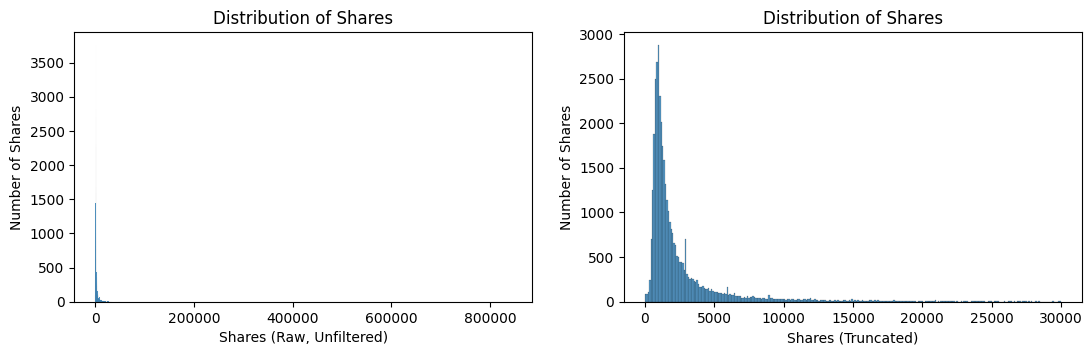

In [15]:
#| echo: false
print("We are predicting shares. \nThe mean of shares is {}. The standard deviation of shares is {}.".format(data.shares.mean(), data.shares.std()))
print("From the distribution of shares, it was evident that it was quite necessary make a log transformation on shares.")
plt.rcParams["figure.figsize"] = [13.00, 3.50]
fig, axes = plt.subplots(1, 2)
num1 = sns.histplot(data.shares, ax = axes[0])
num2 = sns.histplot(data.shares[data.shares.apply(lambda x: False if x > 30000 else True)])
num1.set(xlabel = "Shares (Raw, Unfiltered)", title = "Distribution of Shares", ylabel = "Number of Shares")
num2.set(xlabel = "Shares (Truncated)", title = "Distribution of Shares", ylabel = "Number of Shares")
why = 1

There were 57 variables, some of which were likely unneeded. First, we took out variables that were highly multicorrelated, then we took out variables that were correlated with each other. We first did a coarse search for the right correlation to use, as shown below, before fine tuning the correct correlation to filter out variables while maintaining a good MAE.

In [31]:
#| echo: false
correlation_range = [(x / 10) for x in range(0, 11, 1)]
rmses = pd.DataFrame()
base_model_mae = 2346.631798929844
iteration = 0
for correlation in correlation_range:
    actual_columns_drop = []
    columns_to_drop = []
    X_train_copy = X_train.copy()
    while (True):
        try:
            # Systematically remove variables one by one from dataset copy based on correlation, and break when no more variables to remove
            correlations = X_train_copy.corr(numeric_only = True)
            first_column = correlations.iloc[0].name
            index = correlations[first_column].apply(lambda x: False if x == 1 else True if (np.abs(x) > correlation) else False)
            to_drop = correlations[first_column].loc[index].index.tolist()
            columns_to_drop.append(to_drop)
            X_train_copy = X_train_copy.drop(columns = to_drop).drop(columns = first_column)
        except:
            break
            
    # Make column list of lists of columns into one list of columns
    for columns in columns_to_drop:
        for column in columns:
            actual_columns_drop.append(column)
            
    # Create new model based off of new columns to drop, and then add the rmse to rmses
    model = LinearRegression().fit(X_train.drop(columns = actual_columns_drop), np.log(y_train))
    pred = model.predict(X_test.drop(columns = actual_columns_drop))
    model_rmse = mean_absolute_error(y_test, np.exp(pred))
    
    rmses.loc[iteration, 'MAE'] = model_rmse
    rmses.loc[iteration, 'correlation'] = correlation
    rmses.loc[iteration, 'diff_MAE'] = model_rmse - base_model_mae
    rmses.loc[iteration, 'model'] = model
    rmses.loc[iteration, 'total_dropped'] = len(actual_columns_drop)
    iteration += 1
rmses

,MAE,correlation,diff_MAE,model,total_dropped
0,2376.217700,0.0,29.585901,LinearRegression(),57.0
1,2368.577658,0.1,21.945859,LinearRegression(),47.0
2,2353.893151,0.2,7.261352,LinearRegression(),40.0
3,2328.477566,0.3,-18.154233,LinearRegression(),29.0
4,2322.627474,0.4,-24.004325,LinearRegression(),26.0
5,2329.624071,0.5,-17.007728,LinearRegression(),20.0
6,2317.596518,0.6,-29.035281,LinearRegression(),15.0
7,2317.571526,0.7,-29.060273,LinearRegression(),15.0
8,2312.026782,0.8,-34.605017,LinearRegression(),7.0
9,2369.441261,0.9,22.809462,LinearRegression(),3.0


In [32]:
#| echo: false
X_train = X_train.drop(columns = ['weekday_is_monday',
 'weekday_is_saturday',
 'LDA_00',
 'n_unique_tokens',
 'n_non_stop_words',
 'self_reference_avg_sharess',
 'rate_positive_words',
 'LDA_04',
 'LDA_02',
 'kw_max_max',
 'kw_avg_min',
 'kw_avg_avg',
 'rate_negative_words',
 'min_negative_polarity'])

In [35]:
#| echo: false
pd.set_option('display.max_columns', None)
print("There were no missing values in the predictors used in our models. We also judged it unnecessary to make any investigations \ninto any of the predictors used in model creation")
print("This is the distribution of the predictors used in our models")
X_train.describe()

There were no missing values in the predictors used in our models. We also judged it unnecessary to make any investigations 
into any of the predictors used in model creation
This is the distribution of the predictors used in our models


,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_min_max,kw_avg_max,kw_min_avg,kw_max_avg,self_reference_min_shares,self_reference_max_shares,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_sunday,is_weekend,LDA_01,LDA_03,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000
mean,10.402617,546.024405,0.693708,10.893899,3.298408,4.566041,1.261958,4.549486,7.223301,0.051679,0.179064,0.156803,0.058868,0.187104,0.211162,26.284597,1137.575971,13576.556866,259212.551273,1117.526604,5649.083030,3965.305588,10139.459523,0.185086,0.187766,0.183793,0.143181,0.069242,0.130853,0.141131,0.224729,0.443705,0.119846,0.039660,0.016598,0.354264,0.095802,0.757180,-0.259333,-0.107613,0.282917,0.071555,0.341392,0.156861
std,2.111554,472.583153,3.649366,11.303247,3.826147,8.378235,4.100420,0.839615,1.911541,0.221382,0.383412,0.363620,0.235381,0.390001,0.408139,69.849697,3871.638621,58085.431099,135340.920102,1137.817833,6193.716511,19100.198864,38765.779360,0.388373,0.390531,0.387322,0.350263,0.253869,0.337245,0.219278,0.295801,0.116199,0.097044,0.017464,0.010857,0.104438,0.071767,0.247253,0.127883,0.095513,0.324212,0.266481,0.188892,0.226995
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.380208,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.625566,4.000000,1.000000,1.000000,0.000000,4.478055,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,445.000000,0.000000,172502.857143,0.000000,3563.797735,639.000000,1100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025012,0.028571,0.396621,0.058031,0.028379,0.009585,0.306522,0.050000,0.600000,-0.328593,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,408.000000,0.690987,7.000000,3.000000,1.000000,0.000000,4.663985,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,658.000000,1400.000000,244716.666667,1024.692308,4353.136126,1200.000000,2800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033345,0.040001,0.453349,0.119522,0.039007,0.015337,0.359056,0.100000,0.800000,-0.252889,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,714.000000,0.755319,14.000000,4.000000,4.000000,1.000000,4.854293,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1000.000000,7900.000000,330929.166667,2064.150077,6018.127965,2600.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.151037,0.378857,0.508098,0.178668,0.050314,0.021739,0.411598,0.100000,1.000000,-0.186574,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,650.000000,187.000000,74.0

## Exploratory data analysis

* The only insight is to put a log transformation on the response variable (shares)

## Approach

What kind of a models did you use? What performance metric(s) did you optimize and why?

Is there anything unorthodox / new in your approach? 

What problems did you anticipate? What problems did you encounter? 

Did your problem already have solution(s) (posted on Kaggle or elsewhere). If yes, then how did you build upon those solutions, what did you do differently? Is your model better as compared to those solutions in terms of prediction accuracy or your chosen metric?

**Important: Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.**

We used MARS, CatBoost, XGBoost, and Random Forest models. We optimized MAE, because a large error in model prediction is not significantly worse than a small error in model prediction. Moreover, we did not turn our problem into a classification problem, as we hoped to be able to use our models to predict the relative success of an article, and not just use an arbitrary threshold to predict whether an article is "successful" or a "failure". 

## Developing the model: Hyperparameter tuning

Every person must describe their hyperparameter tuning procedure. Show the grid of hyperparameter values over which the initial search was done *(you may paste your grid search / random search / any other search code)*, and the optimal hyperparameter values obtained. After getting the initial search results, how did you make decisions *(if any)* to further fine-tune your model. Did you do another grid / random search or did you tune hyperparameters sequentially? If you think you didn't need any fine tuning after the initial results, then mention that and explain why.

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### Random Forest
*By Jack O'Keefe*

In [ ]:
from hyperopt import hp, tpe, Trials, fmin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

x_train_encoded = X_train.copy()
y_train = y.copy()

# Define the objective function
def objective(params):
    model = RandomForestRegressor(
        **params,
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(model, X_train, np.log(y_train), cv=5, scoring='neg_mean_squared_error').mean()
    return -score

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 500)),
    'max_depth': hp.choice('max_depth', range(1, 9)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
}

# Run the optimization
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print(best_params)

#### Optimal Hyperparameters 

{'max_depth': 7, 'max_features': 0, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 287}

I first created an untuned random forest and saw the hyperparameter values that were produced from it. That guided by base tuning. I used bayesian optimization because it is much faster than the traditional grid search. This is because it learns from the mistakes of the previous assumptions to more quickly make decisions on the optimal hyperparameters. I ran this twice. 

I was unable to compare my accuracy to the result in the published paper as they made this a classification problem, but the random forest performed better than our other models, initially. This illustrates how there is no one model that is perfectly suited to every dataset. In that case, someone could use XGBoost or CatBoost on every model and hope for the best result. 

### MARS & Catboost 
*By Abenezer Bekele*

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from pyearth import Earth

# Define the model
mars_model = Earth()

# Define the parameters
parameters = {'max_terms': [300,500,1000],
              'max_degree': [1,2,3,4]}

# Define the cross-validator
CV = KFold(n_splits = 5, shuffle=True, random_state=1)

# Initialize the GridSearchCV object
model = GridSearchCV(estimator=mars_model, 
                     param_grid=parameters, 
                     cv=CV, 
                     n_jobs=-1, 
                     verbose=1, 
                     scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the data
model.fit(X_train, y_train)  

# Print the best score and best parameters
print('Best score:', model.best_score_)
print('Best parameters:', model.best_params_)

I utilized the GridSearchCV class from sklearn to optimize the hyperparameters of a MARS model. I first defined the model using the Earth class from pyearth. I set the hyperparameters to be tuned - 'max_terms' and 'max_degree'. I also set up a 5-fold cross-validation using KFold to evaluate the model. I then initialized GridSearchCV with the MARS model, the hyperparameters, cross-validator, and scoring metric (negative mean absolute error). After fitting GridSearchCV on the training data, I printed the best score and the best hyperparameters to understand the model's performance and configuration. The best hyperparameters are {'max_degree': 1, 'max_terms': 300}. 

In [ ]:
mars_model = Earth(max_terms = 300, max_degree = 1)
mars_model = TransformedTargetRegressor(mars_model, func = np.log, inverse_func = np.exp).fit(X_train, y_train)

I then instantiated a MARS model with specified hyperparameters, wrapped it in TransformedTargetRegressor for target transformation, and fit it to the training data.

In [ ]:
#K-fold cross validation to find optimal parameters for CatBoost regressor
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'subsample': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=1, verbose=False),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,random_state = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

I initiated hyperparameter tuning for a CatBoost Regressor using RandomizedSearchCV. I defined a grid for parameters including 'max_depth', 'num_leaves', 'learning_rate', 'reg_lambda', 'n_estimators', and 'subsample'. I used a 5-fold cross-validation with KFold. The RandomizedSearchCV object was configured with 200 iterations, and parallel processing enabled. After fitting it to the training data, I printed the best hyperparameters, the best cross-validation R-squared score, and the time taken for the whole process in minutes. The scores I got are as follows:{'subsample': 0.75, 'reg_lambda': 10, 'num_leaves': 31, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01}. 


In [ ]:
# Instantiate the model with the provided parameters
cat_model = CatBoostRegressor(subsample = 0.75, reg_lambda=10, 
                              depth=6, 
                              n_estimators=1000, 
                              learning_rate=0.01,
                              random_state=1, 
                              verbose=False)

# Fit the model to your training data
cat_model= TransformedTargetRegressor(cat_model, func = np.log, inverse_func = np.exp).fit(X_train, y_train)

# Predict on your test set
y_pred = cat_model.predict(X_test)  

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)  

print('Mean Absolute Error:', mae)

I then created a CatBoost Regressor with specified hyperparameters and wrapped it in a TransformedTargetRegressor for transforming the target variable using logarithm and exponential functions. After fitting the model to the training data, I made predictions on the test set and calculated the Mean Absolute Error (MAE) to evaluate the model's performance, which was then printed.

### Bagged trees & Random forest
*By Fiona Fe*

### XGBoost
*By Ryu Kimiko*

## Model Ensemble 

Put the results of enembling individual models. Feel free to add subsections in this section to add more innovative ensembling methods.

### Voting ensemble

The simplest voting ensemble will be the model where all models have equal weights.

You may come up with innovative methods of estimating weights of the individual models, such as based on their cross-val error. Sometimes, these methods may work better than stacking ensembles, as stacking ensembles tend to overfit.

### Stacking ensemble
Try out different models as the metamodel. You may split work as follows. The person who worked on certain types of models *(say AdaBoost and MARS)* also uses those models as a metamodel in the stacking ensemble.

### Ensemble of ensembled models

If you are creating multiple stacking ensembles *(based on different metamodels)*, you may ensemble them.

### Innovative ensembling methods
*(Optional)*

Some models may do better on certain subsets of the predictor space. You may find that out, and given a data point, choose the model(s) that will best predict for that data point. This is similar to the idea of developing a decision tree metamodel. However, decision tree is prone to overfitting.

Another idea may be to correct the individual models with the intercept and slope *(note the tree-based models don't have an intercept and may suffer from a constant bias)*, and then ensemble them. This is equivalent to having a simple linear regression meta-model for each of the individual models, and then ensembling the meta-models with a meta-metamodel or a voting ensemble.

## Limitations of the model with regard to prediction

Are you confident that you found the optimal hyperparameter values for each of your individual models, and that your individual models cannot be better tuned? Or, are there any models that could be better tuned if you had more time / resources, but you are limited by the amount of time you can spend on the course project *(equivalent to one assignment)*? If yes, then which models could be better tuned and how?

Will it be possible / convenient / expensive for the stakeholders to collect the data relating to the predictors in the model. Using your model, how soon will the stakeholder be able to predict the outcome before the outcome occurs. For example, if the model predicts the number of bikes people will rent in Evanston on a certain day, then how many days before that day will your model be able to make the prediction. This will depend on how soon the data that your model uses becomes available. If you are predicting election results, how many days / weeks / months / years before the election can you predict the results. 

When will your model become too obsolete to be useful?

## Other sections *(optional)*

You are welcome to introduce additional sections or subsections, if required, to address any specific aspects of your project in detail. For example, you may briefly discuss potential future work that the research community could focus on to make further progress in the direction of your project's topic.

## Conclusions and Recommendations to stakeholder(s)

What conclusions do you draw based on your model? You may draw conclusions based on prediction accuracy, or other performance metrics.

How do you use those conclusions to come up with meaningful recommendations for stakeholders? The recommendations must be action-items for stakeholders that they can directly implement without any further analysis. Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

If your recommendations are not practically implementable by stakeholders, how will they help them? Is there some additional data / analysis / domain expertise you need to do to make the recommendations implementable? 

Do the stakeholder(s) need to be aware about some limitations of your model? Is your model only good for one-time use, or is it possible to update your model at a certain frequency (based on recent data) to keep using it in the future? If it can be used in the future, then for how far into the future?

Based on our model, it becomes evident that we did not bring the MAE down to a level where one would be able to make fine, accurate predictions. However, our model would be very useful in being able to predict the general range of popularity an article woudld lie in. For instance, if our model predicted shares of roughly 20,000, it would be clear that that particular article would be relatively popular, regardless of the relative error of the prediction. However, if our model predicts shares in the range of 1000, regardless of the relative error of the prediction it is clear that some work should probably be done on the article to maximize engagement. 

Therefore, what stakeholders should do is use the model to make predictions on a particularly divisive or questionable article to measure the relative success that article would have. Then, depending on the predicted number of shares, and the range of shares the particular firm would be looking to land in, they can decide whether the article is able to be published as is, or needs more work in order to gain more engagement. In this way, they will be able to have relatively consistent high-engagement articles that will drive more readers to their site, increasing their reputation as a publisher with consistently good articles that are worth the reader's time. What would be best to do, however, is use articles written only by the publisher, in order to customize the models towards the publisher's own peculiarities in writing. These more specialized models will likely be able to more accurate predict the publisher's article success, due to the more personable data.

Our model is not only good for a one-time use. Each new batch of recent data from the publisher will be able to be added to the database in order to fit new models to create more accurate predictions. Moreover, given that the predictors used in the models are highly generalizabel to all articles, it will likely be able to be used until articles are no longer being written.

Add details of each team member's contribution, other than the models contributed, in the table below.

<html>
<style>
table, td, th {
  border: 1px solid black;
}

table {
  border-collapse: collapse;
  width: 100%;
}

th {
  text-align: left;
}
    

</style>
<body>

<h2>Individual contribution</h2>

<table style="width:100%">
     <colgroup>
       <col span="1" style="width: 15%;">
       <col span="1" style="width: 20%;">
       <col span="1" style="width: 25%;">
       <col span="1" style="width: 40%;">
    </colgroup>
  <tr>
    <th>Team member</th>
    <th>Individual Model</th>
    <th>Work other than individual model</th>    
    <th>Details of work other than individual model</th>
  </tr>
  <tr>
    <td>Nathan Jung</td>
    <td>XGBoost</td>
    <td></td>    
    <td></td>
  </tr>
  <tr>
    <td>Abenezer Bekele</td>
    <td>MARS, CatBoost</td>
    <td></td>    
    <td> </td>
  </tr>
    <tr>
    <td>Jack O'Keefe</td>
    <td>Random forest</td>
    <td></td>    
    <td></td>
  </tr>
</table>

## References {-}

List and number all bibliographical references. When referenced in the text, enclose the citation number in square brackets, for example [1].

[1] Authors. The frobnicatable foo filter, 2014. Face and Gesture submission ID 324. Supplied as additional material
fg324.pdf. 3


## Appendix {-}

You may put additional stuff here as Appendix. You may refer to the Appendix in the main report to support your arguments. However, the appendix section is unlikely to be checked while grading, unless the grader deems it necessary.